## Necessary libraries

In [1]:
# pip install gensim

In [2]:
# pip install xgboost

In [3]:
# pip install textblob

In [4]:
# pip install string

In [5]:
# Libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import time
import pickle
import gensim
import numpy as np
import nltk

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from scipy import sparse
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

## Handling Raw Corpus

# Loading data and Pre-Processing

In [6]:
data = pd.read_csv("data.tsv", sep='\t')
data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [7]:
data.tail()

,id,tweet,label
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake
6419,6420,It has been 93 days since the last case of COV...,real
6420,6421,The House Democratic Caucus holds a moment of ...,real


In [8]:
import string

In [9]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# Removing punctuations
data['tweet']= data['tweet'].apply(lambda x:remove_punctuation(x))


# Converting text into lower case
data['tweet']= data['tweet'].apply(lambda x: x.lower())


def remove_stopwords(text):
    text = text.split(" ")
    output= " ".join([i for i in text if i not in stopwords])
    return output

stopwords = nltk.corpus.stopwords.words('english')

# Removing stopwords
for i in range(len(data)):
    data["tweet"][i] = remove_stopwords(data["tweet"][i])
    

# Removing urls.....
for i in range(len(data)):
    temp = data["tweet"][i].split(" ")
    if temp[-1].startswith("http"):
        temp.pop()
    data["tweet"][i] = " ".join(temp)

C:\Users\KiranDon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\KiranDon\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
data.head()

,id,tweet,label
0,1,cdc currently reports 99031 deaths general dis...,real
1,2,states reported 1121 deaths small rise last tu...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona 1524 covid testing laborator...,real
4,5,populous states generate large case counts loo...,real


In [11]:
x = data['tweet']
y = data['label']
# print(x)

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=53)

In [13]:
# print(x_train)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
counts = {}
for key in y_train:
    if key in counts:
        counts[key] += 1
    else:
        counts[key] = 1
counts = list(counts.values())

In [16]:
print(counts)

[2333, 2161]


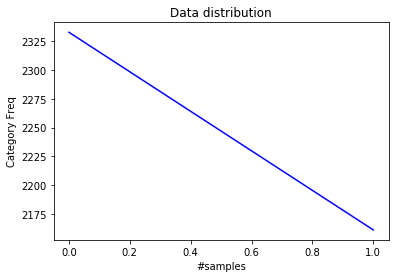

<Figure size 432x288 with 0 Axes>

In [17]:
counts = y_train.value_counts()
plt.plot(range(len(counts)), counts, color='blue')
plt.xlabel('#samples')
plt.ylabel('Category Freq')
plt.title('Data distribution')
plt.show()
plt.savefig('data_distribution_new.png')

In [18]:
# split the dataset into training and validation datasets 
# train_x, test_x, train_y, test_y = model_selection.train_test_split(trainDF['question'], trainDF['main_category'], test_size=0.2, random_state=42)
print(y_train.value_counts())

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = y_train.astype('str')
y_test = y_test.astype('str')
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

classes = list(encoder.classes_)
print(len(classes))

real    2333
fake    2161
Name: label, dtype: int64
2


## Model Traning

In [19]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    
    acc = metrics.accuracy_score(predictions, y_test)
    f1 = metrics.f1_score(predictions, y_test, average='weighted')
#     print(classification_report(predictions, test_y, target_names = list(encoder.classes_)))
#     print(confusion_matrix(predictions, test_y))
    return acc, f1, classifier

## Logistic Regression

## Count Vectorizer

In [20]:
%%time
## Feature Engineering: Counter Vectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat([x_train, x_test], axis=0))

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.fit_transform(x_train)
xvalid_count =  count_vect.transform(x_test)
xtrain_count.shape, xvalid_count.shape

Wall time: 441 ms


((4494, 14203), (1927, 14203))

In [21]:
%%time
# Linear Classifier on Count 
start_t = time.time()
# accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(solver='sag',multi_class='multinomial', max_iter=25000), xtrain_count, train_y, xvalid_count)
accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(solver='sag',multi_class='multinomial', max_iter=250), xtrain_count, y_train, xvalid_count)

# Save the model to output folder
filename = 'count_vec_all.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

# Print Accuracy and F1 score
print("LR, Count Vectors: ", accuracy, f1_score)
end_t = time.time()
print("Time: ",str(end_t-start_t)," secs")

LR, Count Vectors:  0.9206019719771665 0.920604764332611
Time:  1.5598223209381104  secs
Wall time: 1.56 s


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [22]:
with open('count_vec_all.pkl', 'rb') as file_1:
    clf_1 = pickle.load(file_1)
predictions = clf_1.predict(xvalid_count)
acc = metrics.accuracy_score(predictions, y_test)
f1 = metrics.f1_score(predictions, y_test, average='weighted')
print("Accuracy Score: {}".format(acc))
print("f1 Score: {}".format(f1))

Accuracy Score: 0.9206019719771665
f1 Score: 0.920604764332611


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [23]:
del xtrain_count
del xvalid_count
del count_vect

## Word Level TF-IDF

In [24]:
%%time
## Feature Engineering: TF-IDF Vectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern = r'\w{1,}', max_features=5000)
tfidf_vect.fit(pd.concat([x_train, x_test], axis=0))
xtrain_tfidf =  tfidf_vect.transform(x_train)
xvalid_tfidf =  tfidf_vect.transform(x_test)

Wall time: 1.28 s


In [25]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
start_t = time.time()
# accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=25000), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=250), xtrain_tfidf, y_train, xvalid_tfidf)

# Save the model to output folder
filename = 'word-tfidf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

# Print Accuracy and F1 score
print("LR, WordLevel TF-IDF: ", accuracy, f1_score)
end_t = time.time()
print("Time: ",str(end_t-start_t)," secs")
### ======================================== xxxxx =========================================

LR, WordLevel TF-IDF:  0.9242345614945511 0.9242101882106609
Time:  0.09801888465881348  secs
Wall time: 98 ms


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [26]:
with open('word-tfidf.pkl', 'rb') as file_2:
    clf_2 = pickle.load(file_2)
predictions = clf_2.predict(xvalid_tfidf)
acc = metrics.accuracy_score(predictions, y_test)
f1 = metrics.f1_score(predictions, y_test, average='weighted')
print("Accuracy Score: {}".format(acc))
print("f1 Score: {}".format(f1))

Accuracy Score: 0.9242345614945511
f1 Score: 0.9242101882106609


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [27]:
del xtrain_tfidf
del xvalid_tfidf
del tfidf_vect

## NGram Wod TF-IDF

In [28]:
%%time
## Feature Engineering: TF-IDF Vectorizer
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,3), max_features=25000)
tfidf_vect_ngram.fit(pd.concat([x_train, x_test], axis=0))
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

Wall time: 3.27 s


In [29]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
start_t = time.time()
# accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=25000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=250), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)

# Save the model to output folder
filename = 'ngram-tfidf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

# Print Accuracy and F1 score
print("LR, N-Gram Vectors: ", accuracy, f1_score)
end_t = time.time()
print("Time: ",str(end_t-start_t)," secs")
### ======================================== xxxxx =========================================

LR, N-Gram Vectors:  0.8484691229891023 0.8487366018851483
Time:  0.15803956985473633  secs
Wall time: 159 ms


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [30]:
with open('ngram-tfidf.pkl', 'rb') as fp:
    classifier_ = pickle.load(fp)
predictions = classifier_.predict(xvalid_tfidf_ngram)
acc = metrics.accuracy_score(predictions, y_test)
f1 = metrics.f1_score(predictions, y_test, average='weighted')
print("Accuracy Score: {}".format(acc))
print("f1 Score: {}".format(f1))

Accuracy Score: 0.8484691229891023
f1 Score: 0.8487366018851483


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [31]:
del xtrain_tfidf_ngram
del xvalid_tfidf_ngram
del tfidf_vect_ngram

## Char TF-IDF

In [32]:
%%time
## Feature Engineering: TF-IDF Vectorizer
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,3), max_features=25000)
tfidf_vect_ngram_chars.fit(pd.concat([x_train, x_test], axis=0))
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test) 

Wall time: 3.03 s


In [33]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
start_t = time.time()
# accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=25000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
accuracy, f1_score, classifier = train_model(linear_model.LogisticRegression(multi_class='multinomial', solver='sag', max_iter=250), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars)

# Save the model to output folder
filename = 'char-tfidf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

# Print Accuracy and F1 score
print("LR, CharLevel Vectors: ", accuracy, f1_score)
end_t = time.time()
print("Time: ",str(end_t-start_t)," secs")

LR, CharLevel Vectors:  0.9102231447846393 0.9101816570530166
Time:  0.5421440601348877  secs
Wall time: 543 ms


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [34]:
with open('char-tfidf.pkl', 'rb') as fp:
    classifier_ = pickle.load(fp)
predictions = classifier_.predict(xvalid_tfidf_ngram_chars)
acc = metrics.accuracy_score(predictions, y_test)
f1 = metrics.f1_score(predictions, y_test, average='weighted')
print("Accuracy Score: {}".format(acc))
print("f1 Score: {}".format(f1))

Accuracy Score: 0.9102231447846393
f1 Score: 0.9101816570530166


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [35]:
# tweet = ["US COVID-19 EXPERTS said today that USA needs to immediately begin vaccinating A MINIMUM of 100,000 inoculations/day. AT THAT PACE it’ll take a minimum of 660 days to get enough vaccinated - +2 years! Using Trump’s rollout it’ll take 8 years for USA to be vaccinated!"]
tweet = ["The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today."]
# tweet = ["China president xi jinping visited masjid and request Muslims for dua in present crisis country going through.we need your help."]
# tweet = ["Because of Donald Trump's negligence and incompetence:   - More than 110,000 people have died - We have nearly 2 million cases of COVID-19 - Over 20 million Americans are out of work   And yet he’s patting himself on the back. Unbelievable."]
# tweet = ["India has successfully vaccinated all of its population."]
# tweet = ["It's just astounding that the highest rates per capita of covid are in counties that voted solidly for Donald Trump. It's overwhelming since a very significant percentage of our population is kind of in a mass state of denial"]
# tweet = ["An old family friend died from #COVID__19 today. At a hospital in Denver. Because Amarillo hospitals had no room. "]
chars =  tfidf_vect_ngram_chars.transform(tweet)
result = classifier_.predict(chars)[0]
if result==0:
    print("Fake")
else:
    print("Real")

Real


C:\Users\KiranDon\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
